In [2]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [23]:
df = pd.read_csv('./smoke_detection_iot.csv')
df.tail()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
62625,62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0
62629,62629,1655130051,19.299,16.52,643,400,13696,20543,936.676,0.57,0.59,3.90,0.607,0.014,5743,0


In [24]:
df = df.drop(columns=['Unnamed: 0', 'UTC'])
df.tail()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
62625,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0
62629,19.299,16.52,643,400,13696,20543,936.676,0.57,0.59,3.90,0.607,0.014,5743,0


### Normalizando os dados entre 0 e 1

In [25]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### Não existem valores nulos

In [31]:
print(df.isnull().sum())
print(df.isna().sum())

Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64


### Dividindo a base entre treino, teste e validação

In [32]:
X = df.drop(columns = ['Fire Alarm']) # pegando o db sem a variável resposta
y = df['Fire Alarm'] # pegando somente a variável resposta
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=2023)

# Tiro uma parte do teste para colocar na validacao
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.40, random_state=2023)

print(f" Treino {len(X_train)}, Teste {len(X_test)}, Validacao {len(X_val)}")

 Treino 37578, Teste 15031, Validacao 10021


In [33]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',            # Métrica a ser monitorada
    patience=50,               # Número de épocas sem melhoria antes de parar o treinamento
    restore_best_weights=True  # Restaura os melhores pesos encontrados durante o treinamento
)

In [34]:
def lr_scheduler(epoch):
    if epoch < 50:
        return 0.005
    elif epoch < 100:
        return 0.001
    elif epoch < 150:
        return 0.0005
    else:
        return 0.0001

# Criando o callback para o Learning Rate Scheduler
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

### Modelo 1: MLP

In [36]:
model1 = Sequential()

model1.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history1 = model1.fit(
    X_train, 
    y_train, 
    epochs=1000, 
    batch_size=int(0.25 * len(X_train)), 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping_callback, lr_scheduler_callback],
    verbose=1
)

Epoch 1/1000
5/5 [==============================] - 2s 104ms/step - loss: 0.6310 - accuracy: 0.6308 - val_loss: 0.5316 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 2/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.5247 - accuracy: 0.7160 - val_loss: 0.4999 - val_accuracy: 0.7200 - lr: 0.0050
Epoch 3/1000
5/5 [==============================] - 0s 37ms/step - loss: 0.4748 - accuracy: 0.7260 - val_loss: 0.4418 - val_accuracy: 0.7583 - lr: 0.0050
Epoch 4/1000
5/5 [==============================] - 0s 28ms/step - loss: 0.4495 - accuracy: 0.8928 - val_loss: 0.4284 - val_accuracy: 0.9585 - lr: 0.0050
Epoch 5/1000
5/5 [==============================] - 0s 33ms/step - loss: 0.4013 - accuracy: 0.9012 - val_loss: 0.3728 - val_accuracy: 0.7247 - lr: 0.0050
Epoch 6/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.3766 - accuracy: 0.7319 - val_loss: 0.3758 - val_accuracy: 0.7350 - lr: 0.0050
Epoch 7/1000
5/5 [==============================] - 0s 29ms/step - loss: 0.

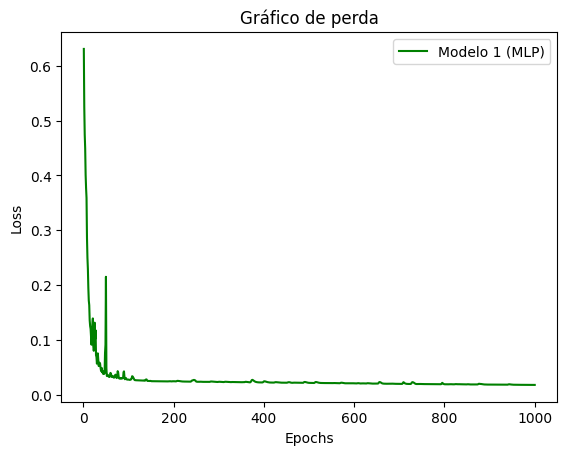

In [39]:
# Grafico do Loss
train_loss1 = history1.history['loss']
epochs = range(1, len(train_loss1) + 1)
plt.plot(epochs, train_loss1, 'g', label='Modelo 1 (MLP)')
plt.title('Gráfico de perda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [41]:
y_train_pred = (model1.predict(X_train) > 0.5).astype("int32")
confusion_train = confusion_matrix(y_train, y_train_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)

print("Matriz de Confusão (Treino):")
print(confusion_train)
print("Acurácia (Treino):", accuracy_train)
print("Recall (Treino):", recall_train)
print("Precisão (Treino):", precision_train)
print("\n")

# Avaliação no conjunto de teste
y_test_pred = (model1.predict(X_test) > 0.5).astype("int32")
confusion_test = confusion_matrix(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)

print("Matriz de Confusão (Teste):")
print(confusion_test)
print("Acurácia (Teste):", accuracy_test)
print("Recall (Teste):", recall_test)
print("Precisão (Teste):", precision_test)

1175/1175 [==============================] - 3s 2ms/step
Matriz de Confusão (Treino):
[[10594    79]
 [   31 26874]]
Acurácia (Treino): 0.9970727553355687
Recall (Treino): 0.9988477978070991
Precisão (Treino): 0.9970689719140726


470/470 [==============================] - 1s 3ms/step
Matriz de Confusão (Teste):
[[ 4291    28]
 [   11 10701]]
Acurácia (Teste): 0.9974053622513472
Recall (Teste): 0.9989731142643764
Precisão (Teste): 0.9973902507223413


In [42]:
y_train_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])